# Paintings with Generative Adversarial Network

Computer vision has advanced tremendously in recent years and GANs are now capable of mimicking objects in a very convincing way. But creating museum-worthy masterpieces is thought of to be, well, more art than science. So can (data) science, in the form of GANs, trick classifiers into believing you’ve created a true Monet? That’s the challenge you’ll take on!

A GAN consists of at least two neural networks: a generator model and a discriminator model. The generator is a neural network that creates the images, while the discriminator determines whether an image is real or not. The two models will work against each other, with the generator trying to trick the discriminator, and the discriminator trying to accurately classify the real vs. generated images.

For this project competition, the goal is to generate 7,000 to 10,000 Monet-style images, obtaining a Memorization-informed Fréchet Inception Distance (MiFID) smaller than 100.

This project's code may be found at [https://github.com/IvMonares/Monet_GAN/](https://github.com/IvMonares/Monet_GAN/blob/main/GAN.ipynb).

## Setup

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

from kaggle_datasets import KaggleDatasets
import matplotlib.pyplot as plt
import numpy as np

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE
    
print(tf.__version__)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Number of replicas: 1
2.13.0


/opt/conda/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


## Data Loading

As this notebook was run in a Kaggle environment, we use the KaggleDatasets().get_gcs_path() function to obtain the path to the image datasets.

In [2]:
GCS_PATH = KaggleDatasets().get_gcs_path()

MONET_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/monet_tfrec/*.tfrec'))
print('Monet TFRecord Files:', len(MONET_FILENAMES))

PHOTO_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/photo_tfrec/*.tfrec'))
print('Photo TFRecord Files:', len(PHOTO_FILENAMES))

Monet TFRecord Files: 5
Photo TFRecord Files: 20


The files are stored in "*.tfrec" format. Therefore, we use the following functions to load and decode the image files.

In [3]:
IMAGE_SIZE = [256, 256]

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset

Finally, we load the datasets to memory using the previous load_dataset() function.

In [4]:
monet_ds = load_dataset(MONET_FILENAMES, labeled=True).batch(1)
photo_ds = load_dataset(PHOTO_FILENAMES, labeled=True).batch(1)

### Exploratory Data Analysis

To ensure that the files were properly loaded, we display a sample from each dataset.

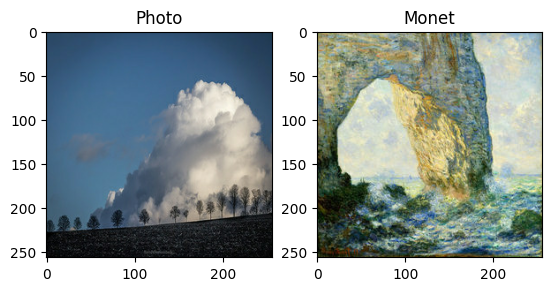

In [5]:
example_monet = next(iter(monet_ds))
example_photo = next(iter(photo_ds))
plt.subplot(121)
plt.title('Photo')
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Monet')
plt.imshow(example_monet[0] * 0.5 + 0.5)

## Data Model Architecture

For the generator and discriminator models we will use helping downsample() and upsample() functions to process the image inputs.

Each downsample will consist of a 2D Convolution layer, a Normalization layer and a Leaky ReLU layer.
Similartly, upsampling will use a 2D Transpose Convolution layer, a Normalization layer and a ReLU layer.

In [6]:
def downsample(filters, size = 4):
    
    return keras.Sequential(
        [
            layers.Conv2D(filters, 
                          size, 
                          strides=2, 
                          padding='same', 
                          kernel_initializer=tf.random_normal_initializer(0., 0.02), 
                          use_bias=False),
            tfa.layers.InstanceNormalization(),
            layers.LeakyReLU()
        ],
    )

In [7]:
def upsample(filters, size = 4):

    return keras.Sequential(
        [
            layers.Conv2DTranspose(filters, 
                                   size, 
                                   strides=2, 
                                   padding='same', 
                                   kernel_initializer=tf.random_normal_initializer(0., 0.02),
                                   use_bias=False),
            tfa.layers.InstanceNormalization(),
            layers.ReLU()
        ],
    )

### Generators

For this project, the generator models will use an adaptation of the U-Net architecture. The input image will be downsampled a number of times with different filters. Then the encoded sample will be upsampled and the previously obtained encoded outputs will be concatenated at each upsample.

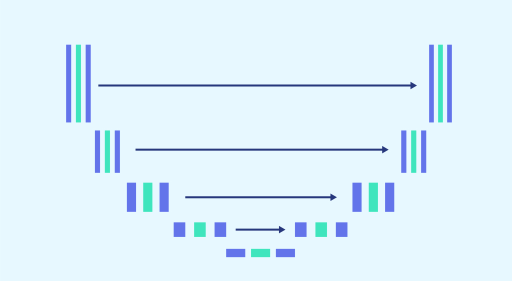

Using long skip connections helps bypass the vanishing gradient problem by concatenating the output of a layer to multiple layers instead of only one.

In [8]:
OUTPUT_CHANNELS = 3

def Generator(filters):
    inputs = layers.Input(shape=[256,256,3])
    x = inputs

    # Downsampling through the model
    skips = []
    for down in filters:
        x = downsample(down)(x)
        skips.append(x)
    
    #Reverse appropriate filters and skip connections
    filters = reversed(filters[1:])
    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(filters, skips):
        x = upsample(up)(x)
        x = layers.Concatenate()([x, skip])

    output = layers.Conv2DTranspose(OUTPUT_CHANNELS, 4, strides=2, padding='same',
                               kernel_initializer=tf.random_normal_initializer(0., 0.02),
                               activation='tanh')(x)
            
    return keras.Model(inputs=inputs, outputs=output)

### Discriminators

The discriminator takes in the input image and classifies it as real or fake (generated). Instead of outputing a single node, the discriminator outputs a smaller 2D image with higher pixel values indicating a real classification and lower values indicating a fake classification.

The architecture for discriminators is almost identical to the first half of the U-Net, downsampling the image using the same filters, and then performing a final 2D convolution to obtain the final output.

In [9]:
def Discriminator(filters):
    
    d_model = keras.Sequential()
    d_model.add(layers.Input(shape=[256, 256, 3]))
    
    for down in filters:
        d_model.add(downsample(down))
        
    d_model.add(layers.ZeroPadding2D())
    d_model.add(layers.Conv2D(1, 4, strides=1, kernel_initializer=tf.random_normal_initializer(0., 0.02)))
    
    return d_model

The training methodology to be used will be the CycleGAN. As such, we require two generators and two discriminators, one set for Monet paintings and one for real-life photographs. The filters to be used for all models is stored within a common filters array.

In [10]:
with strategy.scope():
    filters = [64, 128, 256, 512, 512]
    
    monet_generator = Generator(filters) # transforms photos to Monet-esque paintings
    photo_generator = Generator(filters) # transforms Monet paintings to be more like photos

    monet_discriminator = Discriminator(filters) # differentiates real Monet paintings and generated Monet paintings
    photo_discriminator = Discriminator(filters) # differentiates real photos and generated photos

We can test the newly crated generators to observe how it initially interprets an input image.

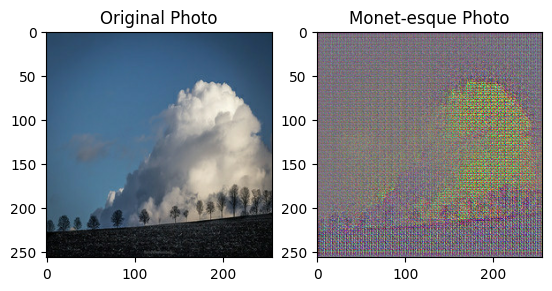

In [11]:
to_monet = monet_generator(example_photo)

plt.subplot(1, 2, 1)
plt.title("Original Photo")
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(1, 2, 2)
plt.title("Monet-esque Photo")
plt.imshow(to_monet[0] * 0.5 + 0.5)
plt.show()

## Model Training

For training both the generators and the discriminators, we will use the CycleGAN methodology, which uses the following elements. 


* The model will transform a photo into a photo. 
  * The difference between the original photo and the self-transformed photo is the identity loss.

* The model will transform a photo to a Monet painting and then back to a photo. 
  * The difference between the original photo and the twice-transformed photo is the cycle-consistency loss, can also be calculated as twice the identity loss.

The same elements will be created for the Monet painting generator.

In [12]:
class CycleGan(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=5,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)
            
            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)
 
            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates cycle consistency loss
            monet_cycle_loss = self.identity_loss_fn(real_monet, cycled_monet, 2 * self.lambda_cycle)
            photo_cycle_loss = self.identity_loss_fn(real_photo, cycled_photo, 2 * self.lambda_cycle)
            total_cycle_loss = monet_cycle_loss + photo_cycle_loss
            
            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss, self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss, self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss, self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss, self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients, self.m_gen.trainable_variables))
        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients, self.p_gen.trainable_variables))
        
        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients, self.m_disc.trainable_variables))
        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients, self.p_disc.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

In [13]:
with strategy.scope():
    def discriminator_loss(real, generated):
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)
        generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)
        return 0.5 * (real_loss + generated_loss)

In [14]:
with strategy.scope():
    def generator_loss(generated):
        return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)

In [15]:
with strategy.scope():
    def identity_loss(real_image, same_image, LAMBDA):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return LAMBDA * loss

Finally, we initialize a GycleGan instance and train all generators and discriminators.

In [16]:
with strategy.scope():
    cycle_gan_model = CycleGan(
        monet_generator, photo_generator, monet_discriminator, photo_discriminator
    )

    cycle_gan_model.compile(
        m_gen_optimizer = tf.keras.optimizers.Adam(3e-4, beta_1=0.5),
        p_gen_optimizer = tf.keras.optimizers.Adam(3e-4, beta_1=0.5),
        m_disc_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5),
        p_disc_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5),
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        identity_loss_fn = identity_loss
    )

In [17]:
cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs=10
)

Epoch 1/10
300/300 [==============================] - 103s 195ms/step - monet_gen_loss: 7.3176 - photo_gen_loss: 7.5049 - monet_disc_loss: 0.7458 - photo_disc_loss: 0.7499
Epoch 2/10
300/300 [==============================] - 59s 193ms/step - monet_gen_loss: 6.5340 - photo_gen_loss: 6.6969 - monet_disc_loss: 0.6984 - photo_disc_loss: 0.6941
Epoch 3/10
300/300 [==============================] - 59s 192ms/step - monet_gen_loss: 6.2400 - photo_gen_loss: 6.3939 - monet_disc_loss: 0.6900 - photo_disc_loss: 0.6812
Epoch 4/10
300/300 [==============================] - 59s 192ms/step - monet_gen_loss: 5.9744 - photo_gen_loss: 6.1205 - monet_disc_loss: 0.6809 - photo_disc_loss: 0.6664
Epoch 5/10
300/300 [==============================] - 59s 193ms/step - monet_gen_loss: 5.8102 - photo_gen_loss: 5.9707 - monet_disc_loss: 0.6709 - photo_disc_loss: 0.6482
Epoch 6/10
300/300 [==============================] - 59s 192ms/step - monet_gen_loss: 5.6720 - photo_gen_loss: 5.8441 - monet_disc_loss: 0.6608

Once all training iterations have been completed, we can once again display some image transformations to visually observe the results.

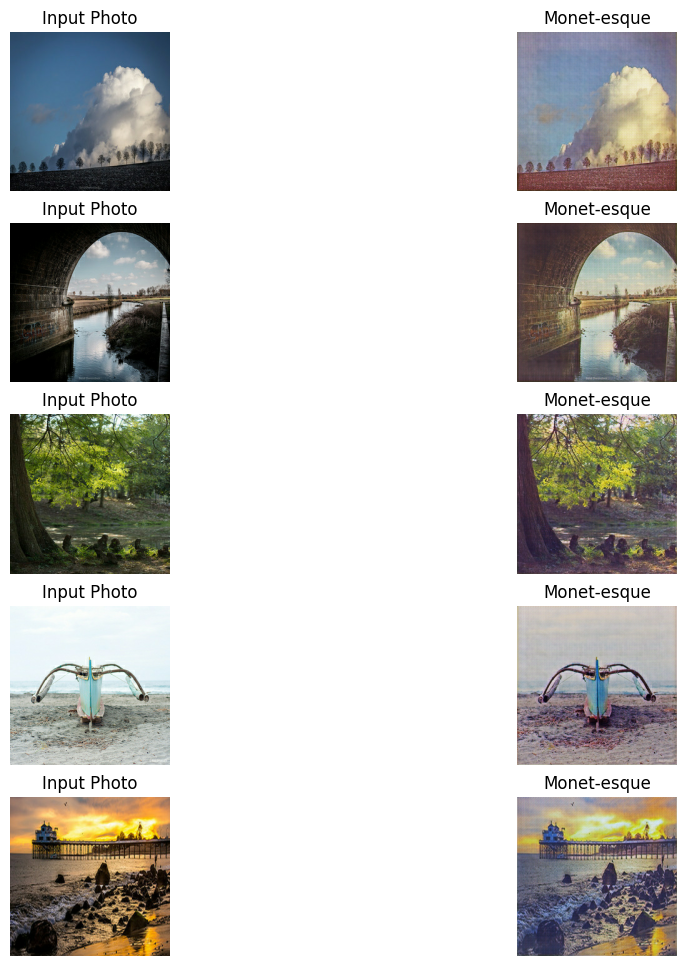

In [18]:
_, ax = plt.subplots(5, 2, figsize=(12, 12))
for i, img in enumerate(photo_ds.take(5)):
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

It is very noticeable that the output images have a different style to their input counterparts while still conserving the shape of what they represent. We can then process all samples and submit them to evaluation to the Kaggle competition discriminator model.

In [19]:
import PIL
! mkdir ../images

In [20]:
i = 1
for img in photo_ds:
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    im.save("../images/" + str(i) + ".jpg")
    i += 1

In [21]:
import shutil
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")

'/kaggle/working/images.zip'

With this architecture, we obtained a score of 63.16. As submissions are evaluated on MiFID (Memorization-informed Fréchet Inception Distance), a small MiFID score indicates good image generation. Therefore the 63.13 score is a very good result. 

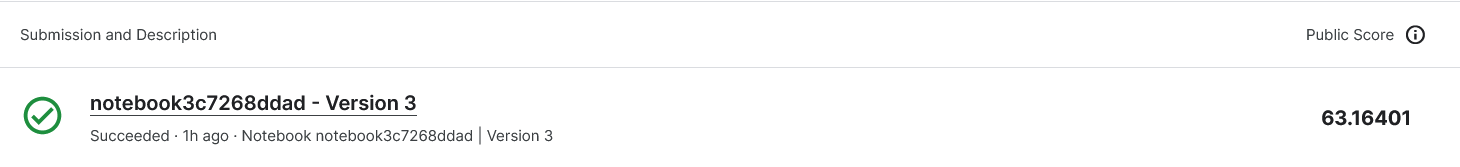

## Alternative Model

An alternative model could be constructed using the same structures, but with a different filter array. Instead of doubling the filters from one layer to the next, we can try with constant increments.

In [23]:
with strategy.scope():
    filters = [64, 128, 192, 256, 320, 384, 448]
    
    monet_generator = Generator(filters) # transforms photos to Monet-esque paintings
    photo_generator = Generator(filters) # transforms Monet paintings to be more like photos

    monet_discriminator = Discriminator(filters) # differentiates real Monet paintings and generated Monet paintings
    photo_discriminator = Discriminator(filters) # differentiates real photos and generated photos

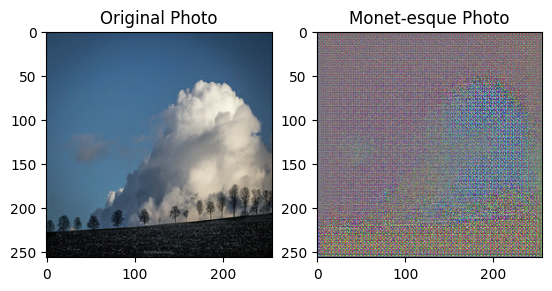

In [24]:
to_monet = monet_generator(example_photo)

plt.subplot(1, 2, 1)
plt.title("Original Photo")
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(1, 2, 2)
plt.title("Monet-esque Photo")
plt.imshow(to_monet[0] * 0.5 + 0.5)
plt.show()

We can observe that the initial transformation has less definition when compared to the initial output of the previous layer. We shall see how big of a difference this represents after training.

In [25]:
with strategy.scope():
    cycle_gan_model = CycleGan(
        monet_generator, photo_generator, monet_discriminator, photo_discriminator
    )

    cycle_gan_model.compile(
        m_gen_optimizer = tf.keras.optimizers.Adam(3e-4, beta_1=0.5),
        p_gen_optimizer = tf.keras.optimizers.Adam(3e-4, beta_1=0.5),
        m_disc_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5),
        p_disc_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5),
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        identity_loss_fn = identity_loss
    )

In [26]:
cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs=10
)

Epoch 1/10
300/300 [==============================] - 119s 185ms/step - monet_gen_loss: 7.7876 - photo_gen_loss: 8.1128 - monet_disc_loss: 0.8797 - photo_disc_loss: 0.8551
Epoch 2/10
300/300 [==============================] - 56s 185ms/step - monet_gen_loss: 6.8449 - photo_gen_loss: 7.0875 - monet_disc_loss: 0.7308 - photo_disc_loss: 0.7120
Epoch 3/10
300/300 [==============================] - 57s 185ms/step - monet_gen_loss: 6.5825 - photo_gen_loss: 6.7607 - monet_disc_loss: 0.6839 - photo_disc_loss: 0.6697
Epoch 4/10
300/300 [==============================] - 57s 185ms/step - monet_gen_loss: 6.4860 - photo_gen_loss: 6.5801 - monet_disc_loss: 0.6294 - photo_disc_loss: 0.6610
Epoch 5/10
300/300 [==============================] - 57s 185ms/step - monet_gen_loss: 6.3996 - photo_gen_loss: 6.4817 - monet_disc_loss: 0.6002 - photo_disc_loss: 0.6216
Epoch 6/10
300/300 [==============================] - 57s 185ms/step - monet_gen_loss: 6.3590 - photo_gen_loss: 6.3195 - monet_disc_loss: 0.5701

This new model had an almost identical training time, but we can see that the generator loss appears to be larger. We can display some samples to evaluate how are the transformations.

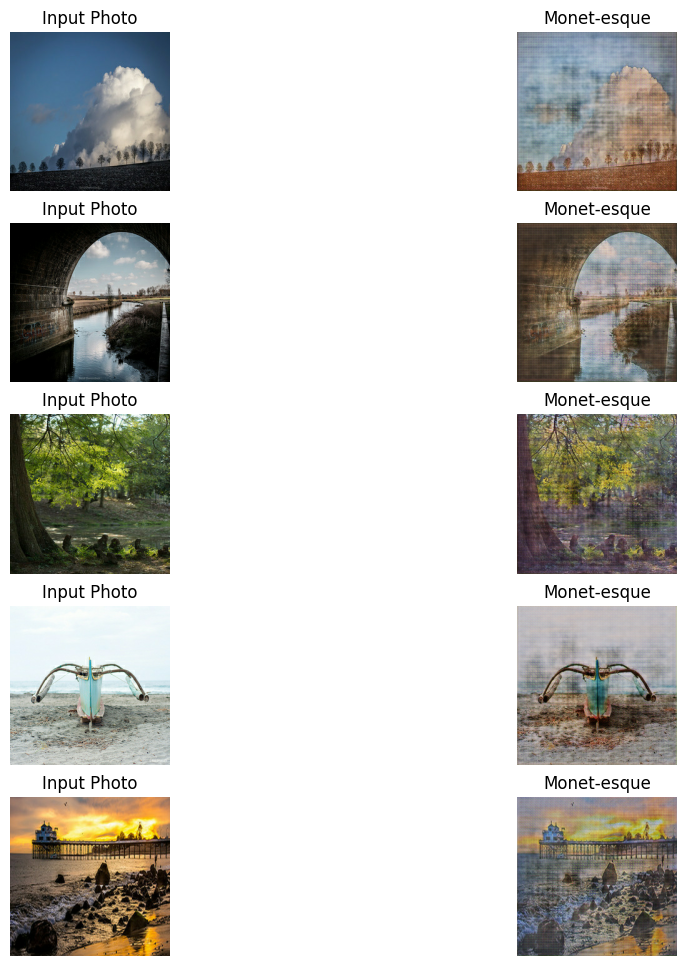

In [27]:
_, ax = plt.subplots(5, 2, figsize=(12, 12))
for i, img in enumerate(photo_ds.take(5)):
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

While they do conserve the original shape of the original photo, the Monet transformations are noisier that that of the original model.

In [28]:
import os
os.remove("/kaggle/working/images.zip") 

In [29]:
import PIL
! mkdir ../images2

In [30]:
i = 1
for img in photo_ds:
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    im.save("../images2/" + str(i) + ".jpg")
    i += 1

In [31]:
import shutil
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images2")

'/kaggle/working/images.zip'

This second architecture achieved a score of 82.71. While still quite good, it is a definite step-back from the previous model.

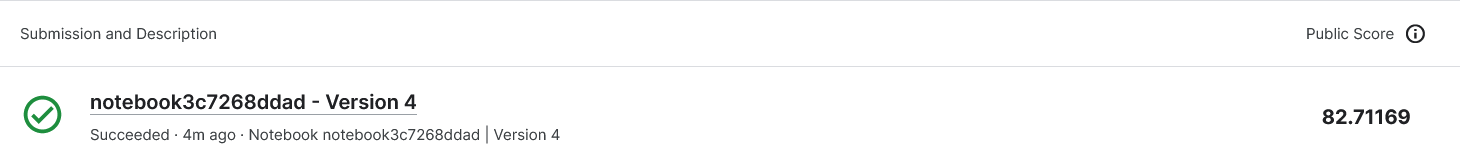

We could make a final attempt on the incremental model by limiting the number of applied filters back to 5.

In [ ]:
with strategy.scope():
    filters = [64, 128, 192, 256, 320]
    
    monet_generator = Generator(filters) # transforms photos to Monet-esque paintings
    photo_generator = Generator(filters) # transforms Monet paintings to be more like photos

    monet_discriminator = Discriminator(filters) # differentiates real Monet paintings and generated Monet paintings
    photo_discriminator = Discriminator(filters) # differentiates real photos and generated photos

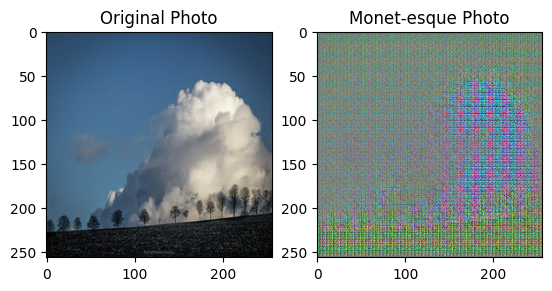

In [ ]:
to_monet = monet_generator(example_photo)

plt.subplot(1, 2, 1)
plt.title("Original Photo")
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(1, 2, 2)
plt.title("Monet-esque Photo")
plt.imshow(to_monet[0] * 0.5 + 0.5)
plt.show()

In [ ]:
with strategy.scope():
    cycle_gan_model = CycleGan(
        monet_generator, photo_generator, monet_discriminator, photo_discriminator
    )

    cycle_gan_model.compile(
        m_gen_optimizer = tf.keras.optimizers.Adam(3e-4, beta_1=0.5),
        p_gen_optimizer = tf.keras.optimizers.Adam(3e-4, beta_1=0.5),
        m_disc_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5),
        p_disc_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5),
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        identity_loss_fn = identity_loss
    )

In [ ]:
cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs=10
)

Epoch 1/10
300/300 [==============================] - 88s 135ms/step - monet_gen_loss: 7.2401 - photo_gen_loss: 7.4266 - monet_disc_loss: 0.7104 - photo_disc_loss: 0.7111
Epoch 2/10
300/300 [==============================] - 46s 137ms/step - monet_gen_loss: 6.4833 - photo_gen_loss: 6.6627 - monet_disc_loss: 0.6893 - photo_disc_loss: 0.6869
Epoch 3/10
300/300 [==============================] - 44s 130ms/step - monet_gen_loss: 6.1719 - photo_gen_loss: 6.3398 - monet_disc_loss: 0.6825 - photo_disc_loss: 0.6753
Epoch 4/10
300/300 [==============================] - 45s 134ms/step - monet_gen_loss: 5.9350 - photo_gen_loss: 6.0909 - monet_disc_loss: 0.6735 - photo_disc_loss: 0.6572
Epoch 5/10
300/300 [==============================] - 45s 134ms/step - monet_gen_loss: 5.6954 - photo_gen_loss: 5.8443 - monet_disc_loss: 0.6643 - photo_disc_loss: 0.6445
Epoch 6/10
300/300 [==============================] - 45s 134ms/step - monet_gen_loss: 5.6230 - photo_gen_loss: 5.7659 - monet_disc_loss: 0.6515 

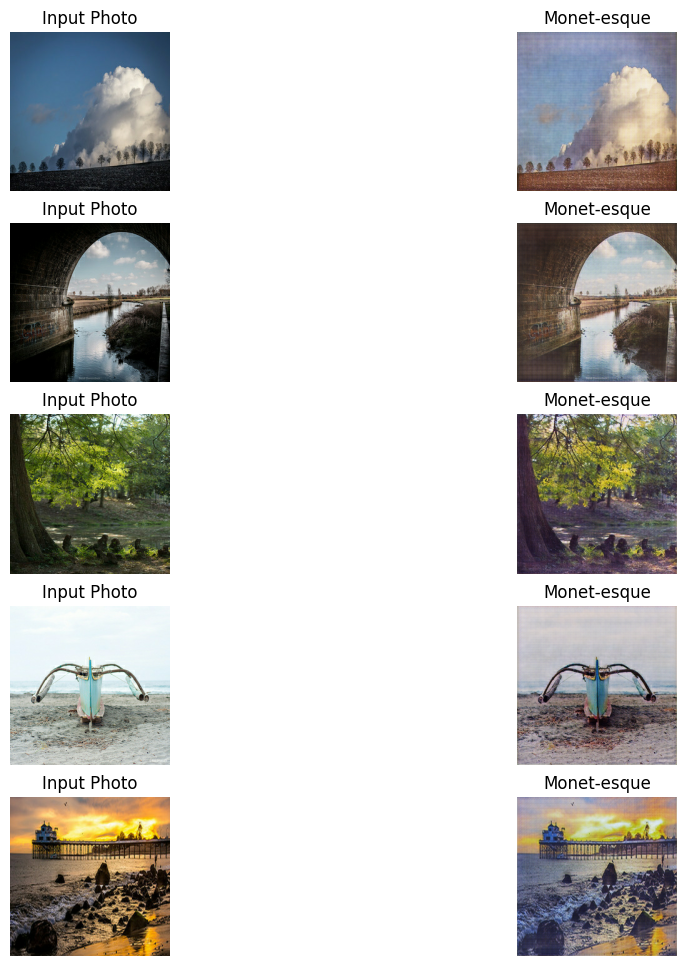

In [ ]:
_, ax = plt.subplots(5, 2, figsize=(12, 12))
for i, img in enumerate(photo_ds.take(5)):
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

This results are much better than with the previous model. We have only left to see how they fare against the first architecture model.

In [ ]:
import os
os.remove("/kaggle/working/images.zip") 

In [ ]:
import PIL
! mkdir ../images3

In [ ]:
i = 1
for img in photo_ds:
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    im.save("../images3/" + str(i) + ".jpg")
    i += 1

In [ ]:
import shutil
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images3")

'/kaggle/working/images.zip'

This model was an improvement, obtaining a score back to 68.85. This is quite similar to that of the first model with three-quarters of the training time.

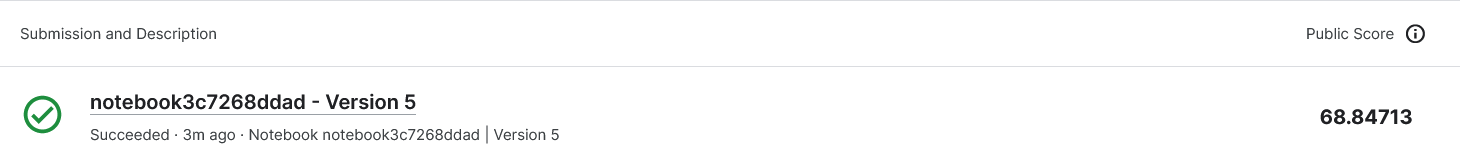

## Conclusions

### Learnings

The proposed models achieved the goal of obtaining an MiFID score smaller than 100. We also see that adding more filters will not necessarily give us a better generated image, and we must therefore properly manage the models architecture and its training to achieve good results.

### Future works

Future works could focus on attempting other downsampling and upsampling functions to obtain different results. They can also focus on larger changes to the model's architecture themselves, or in using another variant of discriminators to train the generators.

## References

* [Amy Jang, Ana Sofia Uzsoy, Phil Culliton. (2020). I’m Something of a Painter Myself. Kaggle.](https://kaggle.com/competitions/gan-getting-started)
* [Amy Jang. (2020) I’m Something of a Painter Myself: Monet CycleGAN Tutorial. Kaggle.](https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial/)
* [Aakash Kumar Nain. (2020) CycleGAN. Keras.](https://keras.io/examples/generative/cyclegan/)
* [François Cholle. (2017) Building Autoencoders in Keras. Keras.](https://blog.keras.io/building-autoencoders-in-keras.html)
* [François Cholle. (2021) DCGAN to generate face images. Keras.](https://keras.io/examples/generative/dcgan_overriding_train_step/)
* [Aditya Tapari. U-Net Architecture Explained. GeeksForGeeks.](https://www.geeksforgeeks.org/u-net-architecture-explained/)